📖 Reading data from csv...
📈 Calculating net liquidity value over time...
📊 Plotting the graph...


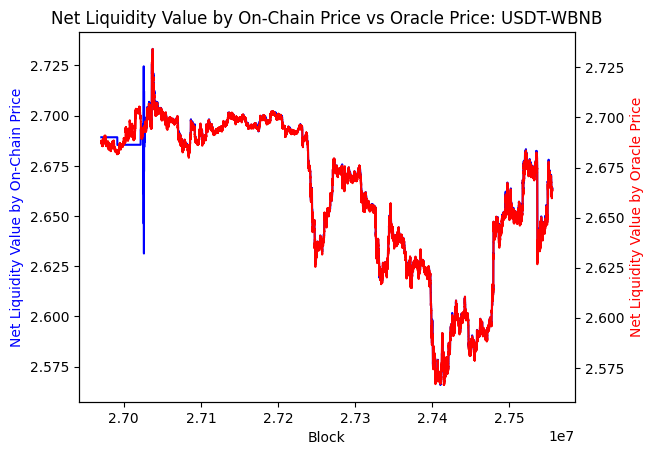

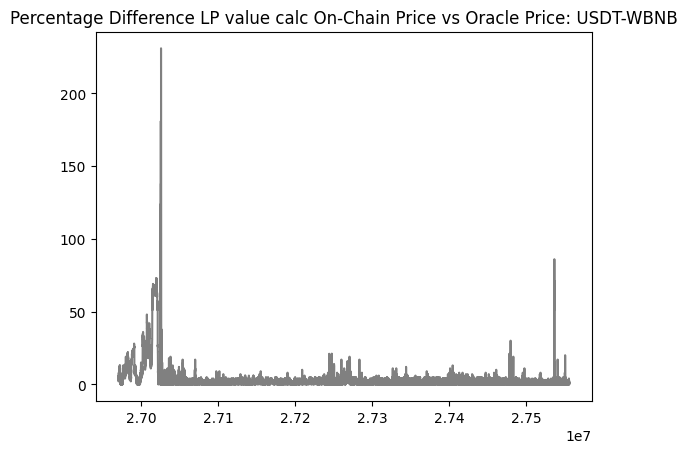

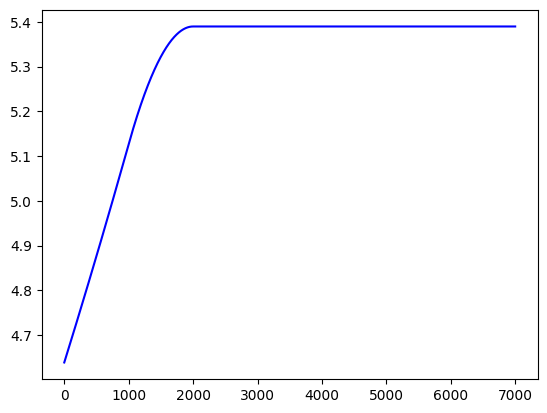

🟢 Done
0
13863
6931


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from web3 import Web3
from web3.middleware import geth_poa_middleware
from dotenv import load_dotenv
import os
import requests
import csv

# ════════════════════════════════════════
#            FUNCTION DEFINITIONS
# ════════════════════════════════════════


def percentage_diff(number1, number2):
    return math.floor((abs(number1 - number2) / number1) * 10000)


def price_at(tick):
    return math.pow(1.0001, tick)


def tick_at(price):
    return math.floor(math.log(price) / math.log(1.0001))


def sqrt_price_x96_to_price(sqrt_price_x96):
    return math.pow(sqrt_price_x96, 2) / 2**192


def get_amount0_for_liquidity(tickA, tickB, liquidity):
    # tickA must be a lower tick so swap if tickA > tickB
    if tickA > tickB:
        tickA, tickB = tickB, tickA

    sqrtPriceA = math.sqrt(price_at(tickA))
    sqrtPriceB = math.sqrt(price_at(tickB))
    return (liquidity * (sqrtPriceB - sqrtPriceA) / sqrtPriceB) / sqrtPriceA


def get_amount1_for_liquidity(tickA, tickB, liquidity):
    if tickA > tickB:
        tickA, tickB = tickB, tickA

    sqrtPriceA = math.sqrt(price_at(tickA))
    sqrtPriceB = math.sqrt(price_at(tickB))
    return liquidity * (sqrtPriceB - sqrtPriceA)


# Return liquidity value
def calc_liquidity_value(curr_tick, tick_lower, tick_upper, t0_t1_price, liquidity):
    if curr_tick < tick_lower:
        amount0 = get_amount0_for_liquidity(tick_lower, tick_upper, liquidity)
        return amount0 * t0_t1_price
    elif curr_tick > tick_upper:
        amount1 = get_amount1_for_liquidity(tick_lower, tick_upper, liquidity)
        return amount1
    else:
        amount0 = get_amount0_for_liquidity(curr_tick, tick_upper, liquidity)
        amount1 = get_amount1_for_liquidity(tick_lower, curr_tick, liquidity)
        return amount0 * t0_t1_price + amount1


# Etherscan class to interact with Etherscan API
class Etherscan:
    api_url = ""
    api_key = ""

    def __init__(self, chain_id):
        load_dotenv()
        if chain_id == 56:
            if os.getenv("BSCSCAN_API_KEY") is None:
                raise ValueError("BSCSCAN_API_KEY not found in .env file")
            self.api_url = "https://api.bscscan.com/api"
            self.api_key = os.getenv("BSCSCAN_API_KEY")
        else:
            raise ValueError("Unsupported chain_id")

    def get_abi(self, address):
        response = requests.get(
            f"{self.api_url}?module=contract&action=getabi&address={address}&apikey={self.api_key}"
        ).json()
        return response.get("result")


def download_data_on_chain(
    pool_address, token0_oracle_address, token1_oracle_address, from_block, to_block
):
    load_dotenv()
    if os.getenv("BSC_RPC_API") is None:
        raise ValueError("BSC_RPC_API not found in .env file")

    print("⛓ Downloading data from blockchain...")
    bscscan = Etherscan(56)
    w3 = Web3(Web3.HTTPProvider(os.getenv("BSC_RPC_API")))
    w3.middleware_onion.inject(geth_poa_middleware, layer=0)

    # Download data from blockchain
    pool_instance = w3.eth.contract(
        address=pool_address,
        abi=bscscan.get_abi(pool_address),
    )
    token0_address = pool_instance.functions.token0().call()
    token0_instance = w3.eth.contract(
        address=token0_address, abi=bscscan.get_abi(token0_address)
    )
    token1_address = pool_instance.functions.token1().call()
    token1_instance = w3.eth.contract(
        address=token1_address, abi=bscscan.get_abi(token0_address)
    )
    pool_fee = pool_instance.functions.fee().call()
    token0_symbol = token0_instance.functions.symbol().call()
    token1_symbol = token1_instance.functions.symbol().call()
    token0_oracle_instance = w3.eth.contract(
        address=token0_oracle_address, abi=bscscan.get_abi(token0_oracle_address)
    )
    token1_oracle_instance = w3.eth.contract(
        address=token1_oracle_address, abi=bscscan.get_abi(token1_oracle_address)
    )
    data = [
        [
            "block",
            "sqrtPriceX96",
            "tick",
            "token0_usd_oracle_price",
            "token1_usd_oracle_price",
        ]
    ]
    processed_blocks = 0
    for i in range(from_block, to_block):
        if processed_blocks % 10 == 0:
            print(f"👩‍🚒 Processed {processed_blocks} blocks, {to_block - i} left...")

        slot0 = pool_instance.functions.slot0().call(block_identifier=i)
        token0_oracle_price = (
            token0_oracle_instance.functions.latestAnswer().call(block_identifier=i)
            / 1e8
        )
        token1_oracle_price = (
            token1_oracle_instance.functions.latestAnswer().call(block_identifier=i)
            / 1e8
        )
        data.append(
            [
                i,
                slot0[0],
                slot0[1],
                token0_oracle_price,
                token1_oracle_price,
            ]
        )
        processed_blocks += 1
        with open(
            f"./out/{token0_symbol}{token1_symbol}{pool_fee}_pool_data.csv",
            "w",
            newline="",
        ) as file:
            writer = csv.writer(file)
            writer.writerows(data)
    print("🟢 Done")


# ═══════════════════════════════════════
#                   LOGIC
# ═══════════════════════════════════════

rows = []
# read data from csv
print("📖 Reading data from csv...")
with open(
    "./data/pancake-v3-0x36696169C63e42cd08ce11f5deeBbCeBae652050.csv", "r"
) as file:
    reader = csv.reader(file)
    for index, row in enumerate(reader):
        if index == 0:
            # skip header
            continue
        rows.append(row)

# create data points
if len(rows) == 0:
    raise ValueError("No data found in csv file")

# decide on tick lower and tick upper
price_ref = price_at(int(rows[0][2]))
# assuming the band is +-5%
tick_lower = tick_at(price_ref * 0.5)
tick_upper = tick_at(price_ref * 1.5)
# assuming we holds 100 liquidity
liquidity = 100

# calculate net liquidity value over time for each data point
print("📈 Calculating net liquidity value over time...")
x_blocks = []
y_net_liquidity_values_by_on_chain = []
y_net_liquidity_values_by_oracle_price = []
y_token0_token1_oracle_price = []
y_percentage_diff = []
for row in rows:
    block = int(row[0])
    sqrt_price_x96 = row[1]
    tick = int(row[2])
    token0_usd_oracle_price = float(row[3])
    token1_usd_oracle_price = float(row[4])

    token0_token1_oracle_price = token0_usd_oracle_price / token1_usd_oracle_price

    # calculate net liquidity value
    x_blocks.append(block)
    y_net_liquidity_values_by_on_chain.append(
        calc_liquidity_value(
            tick,
            tick_lower,
            tick_upper,
            price_at(tick),
            liquidity,
        )
    )
    y_net_liquidity_values_by_oracle_price.append(
        calc_liquidity_value(
            tick_at(token0_token1_oracle_price),
            tick_lower,
            tick_upper,
            token0_token1_oracle_price,
            liquidity,
        )
    )
    y_token0_token1_oracle_price.append(token0_token1_oracle_price)
    y_percentage_diff.append(
        percentage_diff(
            y_net_liquidity_values_by_oracle_price[-1],
            y_net_liquidity_values_by_on_chain[-1],
        )
    )

# plot the graph
print("📊 Plotting the graph...")
# create the first set of axes
net_liquidity_value_on_chain_vs_oracle_fig, ax1 = plt.subplots()

# plot the first data set on the first set of axes
ax1.plot(x_blocks, y_net_liquidity_values_by_on_chain, color="blue")
ax1.set_title("Net Liquidity Value by On-Chain Price vs Oracle Price: USDT-WBNB")
ax1.set_xlabel("Block")
ax1.set_ylabel("Net Liquidity Value by On-Chain Price", color="blue")

# create the second set of axes that share the same x-axis as the first
ax2 = ax1.twinx()
# plot the second data set on the second set of axes
ax2.plot(x_blocks, y_net_liquidity_values_by_oracle_price, color="red")
ax2.set_ylabel("Net Liquidity Value by Oracle Price", color="red")

# plot the % diff on the new graph
# create a % diff figure
percentage_diff_fig, ax3 = plt.subplots()

# plot the % diff on the new figure
ax3.plot(x_blocks, y_percentage_diff, color="grey")
ax3.set_title(
    "Percentage Difference LP value calc On-Chain Price vs Oracle Price: USDT-WBNB"
)

# liquidty tick
x_ticks = np.arange(7000)
y_liquidity_value = []
TICK_LOWER = 1000
TICK_UPPER = 2000

for tick in x_ticks:
    y_liquidity_value.append(
        calc_liquidity_value(
            tick,
            TICK_LOWER,
            TICK_UPPER,
            price_at(tick),
            100,
        )
    )

liquidity_fig, ax4 = plt.subplots()
ax4.plot(x_ticks, y_liquidity_value, color="blue")


# show
plt.show()

print("🟢 Done")

print(tick_at(1))
print(tick_at(4))
print(tick_at(0.0000000000005))

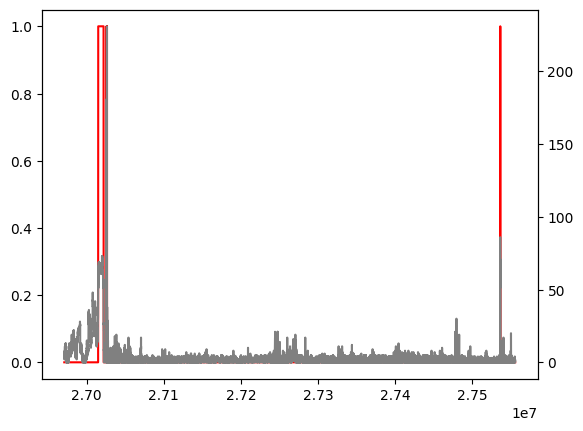

In [4]:
# Build test input file
from eth_abi import encode

maxPriceDiff = 10050
test_input_output = []
byte_test_case_output = []
y_is_revert = []
for index, row in enumerate(rows):
    tick = int(row[2])
    token0_usd_oracle_price = float(row[3])
    token1_usd_oracle_price = float(row[4])
    is_revert = (
        y_net_liquidity_values_by_on_chain[index] * 10000
        > y_net_liquidity_values_by_oracle_price[index] * maxPriceDiff
        or y_net_liquidity_values_by_on_chain[index] * maxPriceDiff
        < y_net_liquidity_values_by_oracle_price[index] * 10000
    )

    y_is_revert.append(1 if is_revert == True else 0)
    test_input_output.append(
        [
            encode(
                ["int24", "uint256", "uint256", "bool"],
                [
                    tick,
                    int(token0_usd_oracle_price * 1e8),
                    int(token1_usd_oracle_price * 1e8),
                    is_revert,
                ],
            ).hex(),
            tick,
            y_net_liquidity_values_by_on_chain[index],
            y_net_liquidity_values_by_oracle_price[index],
            token0_usd_oracle_price,
            token1_usd_oracle_price,
            is_revert,
        ]
    )
    byte_test_case_output.append(
        [
            encode(
                ["int24", "uint256", "uint256", "bool"],
                [
                    tick,
                    int(token0_usd_oracle_price * 1e8),
                    int(token1_usd_oracle_price * 1e8),
                    is_revert,
                ],
            ).hex()
        ]
    )
# write to csv
with open(
    "./test-input/pancake-v3-0x36696169C63e42cd08ce11f5deeBbCeBae652050.csv",
    "w",
    newline="",
) as file:
    writer = csv.writer(file)
    writer.writerows(test_input_output)

# write to csv
with open(
    "./test-input/0x36696169C63e42cd08ce11f5deeBbCeBae652050.csv",
    "w",
    newline="",
) as file:
    writer = csv.writer(file)
    writer.writerows(byte_test_case_output)

# create the first set of axes
is_revert_fig, ax4 = plt.subplots()

# plot the first data set on the first set of axes
ax4.plot(x_blocks, y_is_revert, color="red")

# create the second set of axes that share the same x-axis as the first
ax5 = ax4.twinx()
# plot the second data set on the second set of axes
ax5.plot(x_blocks, y_percentage_diff, color="grey")

# show
plt.show()